In [2]:
import tensorflow as tf

In [2]:
v = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
with tf.Session() as sess:
    # 限制范围
    print(tf.clip_by_value(v, 2.5, 4.5).eval())
    # 取自然对数
    print(tf.log(v).eval())
    # 取平均值
    print(tf.reduce_mean(v).eval())

[[2.5 2.5 3. ]
 [4.  4.5 4.5]]
[[0.        0.6931472 1.0986123]
 [1.3862944 1.609438  1.7917595]]
3.5


In [4]:
v1 = tf.constant([[1.0, 2.0], [3.0, 4.0]])
v2 = tf.constant([[5.0, 6.0], [7.0, 8.0]])
with tf.Session() as sess:
    # 对应元素间相乘
    print((v1 * v2).eval())
    # 矩阵乘法
    print(tf.matmul(v1, v2).eval())

[[ 5. 12.]
 [21. 32.]]
[[19. 22.]
 [43. 50.]]


In [4]:
v1 = tf.constant([1.0, 2.0, 3.0, 4.0])
v2 = tf.constant([4.0, 3.0, 2.0, 1.0])
with tf.Session() as sess:
    # tf.reduce_sum
    print(tf.reduce_sum(v1).eval())
    # tf.greater
    print(tf.greater(v1, v2).eval())
    # tf.where
    print(tf.where(tf.greater(v1, v2), v1, v2).eval())

10.0
[False False  True  True]
[4. 3. 3. 4.]


In [7]:
classes = ['0','1','2','3','4','5','6','7','8','9']
for index, name in enumerate(classes):
        print(index,'--',name)

0 -- 0
1 -- 1
2 -- 2
3 -- 3
4 -- 4
5 -- 5
6 -- 6
7 -- 7
8 -- 8
9 -- 9


In [2]:
# 无隐层（无激活函数）实现自定义损失函数的神经网络训练
import matplotlib.pyplot as plt
import tensorflow as tf
# 通过numpy生成模拟数据集
from numpy.random import RandomState

%matplotlib inline

costs = []
# 训练数据批次大小
batch_size=8

# 定义权重
w1 = tf.Variable(tf.random_normal([2,1],stddev=1,seed=1))

# 定义输入和输出占位空间
x = tf.placeholder(tf.float32,shape=(None,2),name='x_input')
y_ = tf.placeholder(tf.float32,shape=(None,1),name ='y_input')

# 定义前向传播
y = tf.matmul(x,w1)

#定义预测多了和少了的成本（损失系数）
loss_less = 10
loss_more = 1

#自定义损失函数和反向传播的算法（Adam）
loss = tf.reduce_sum(tf.where(tf.greater(y,y_),
                               (y-y_)*loss_more,(y_-y)*loss_less))

train_step = tf.train.AdamOptimizer(0.001).minimize(loss)  # 0.001学习率，最小化损失

# 通过随机数生成模拟数据集
rdm = RandomState(1)
dataset_size=128  # 数据集大小
X = rdm.rand(dataset_size,2) # 维度
#加入了一个噪音值，-0.05～0.05之间
Y = [[x1+x2+rdm.rand()/10.0-0.05] for (x1,x2) in X]  # 定义正确值标签

# 创建会话运行训练过程
with tf.Session() as sess:
    # 初始化变量
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    print (sess.run(w1))
    
    # 定义训练轮数
    steps = 5000
    for i in range(steps):
        # 每次选取batch_size个样本训练
        start = (i*batch_size)%dataset_size
        end = min(start+batch_size,dataset_size)
        
        # 训练并更新参数,feed_dict喂入数据到占位空间
        sess.run(train_step,feed_dict = {x:X[start:end],y_:Y[start:end]})
        # 打印损失值
        if i%1000==0:
            total_loss = sess.run(
                loss,feed_dict={x:X,y_:Y})
            print("After %d training_step(s) ,loss on all data is %g"%(i,total_loss))
            costs.append(total_loss)
     # 打印训练后的权重值       
    print (sess.run(w1))
    
    # 显示损失曲线
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = 0.001")
    plt.show()

KeyboardInterrupt: 

[[-0.8113182]
 [ 1.4845988]]
After 0 training_step(s) ,loss on all data is 658.783
After 1000 training_step(s) ,loss on all data is 8.8205
After 2000 training_step(s) ,loss on all data is 7.31111
After 3000 training_step(s) ,loss on all data is 7.68647
After 4000 training_step(s) ,loss on all data is 9.38618
[[1.0159413]
 [1.0480963]]


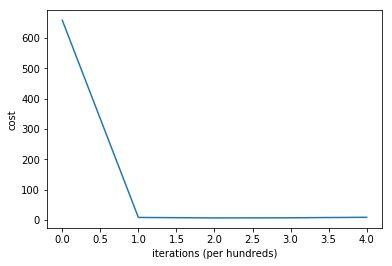

In [6]:
# 无隐层（无激活函数）实现自定义损失函数的神经网络训练
# 加入L2正则化损失,加入学习率的设置（指数衰减）
import matplotlib.pyplot as plt
import tensorflow as tf
# 通过numpy生成模拟数据集
from numpy.random import RandomState

%matplotlib inline

costs = []
# 训练数据批次大小
batch_size=8

# 定义权重
w1 = tf.Variable(tf.random_normal([2,1],stddev=1,seed=1))

# 定义输入和输出占位空间
x = tf.placeholder(tf.float32,shape=(None,2),name='x_input')
y_ = tf.placeholder(tf.float32,shape=(None,1),name ='y_input')

# 定义前向传播
y = tf.matmul(x,w1)

#定义预测多了和少了的成本（损失系数）
loss_less = 10
loss_more = 1

#自定义损失函数+L2正则化损失，反向传播的算法（梯度下降法）
loss = tf.reduce_sum(tf.where(tf.greater(y,y_),
                               (y-y_)*loss_more,(y_-y)*loss_less)) + tf.contrib.layers.l2_regularizer(0.5)(w1)

global_step = tf.Variable(0)
# 学习率的设置：指数衰减法，参数：初始参数，全局步骤，每训练100轮乘以衰减速度0,96(当staircase=True的时候)
learning_rate = tf.train.exponential_decay(0.1,global_step,100,0.96,staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)

# 通过随机数生成模拟数据集
rdm = RandomState(1)
dataset_size=128  # 数据集大小
X = rdm.rand(dataset_size,2) # 维度
#加入了一个噪音值，-0.05～0.05之间
Y = [[x1+x2+rdm.rand()/10.0-0.05] for (x1,x2) in X]  # 定义正确值标签

# 创建会话运行训练过程
with tf.Session() as sess:
    # 初始化变量
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    print (sess.run(w1))
    
    # 定义训练轮数
    steps = 5000
    for i in range(steps):
        # 每次选取batch_size个样本训练
        start = (i*batch_size)%dataset_size
        end = min(start+batch_size,dataset_size)
        
        # 训练并更新参数,feed_dict喂入数据到占位空间
        sess.run(train_step,feed_dict = {x:X[start:end],y_:Y[start:end]})
        # 打印损失值
        if i%1000==0:
            total_loss = sess.run(
                loss,feed_dict={x:X,y_:Y})
            print("After %d training_step(s) ,loss on all data is %g"%(i,total_loss))
            costs.append(total_loss)
     # 打印训练后的权重值       
    print (sess.run(w1))
    
# 显示损失曲线 
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
#plt.title("Learning rate = 0.001")
plt.show()

After 0 training_step(s) ,loss on all data is 1.3481
After 1000 training_step(s) ,loss on all data is 1.32641
After 2000 training_step(s) ,loss on all data is 1.31387
After 3000 training_step(s) ,loss on all data is 1.30627
After 4000 training_step(s) ,loss on all data is 1.30153


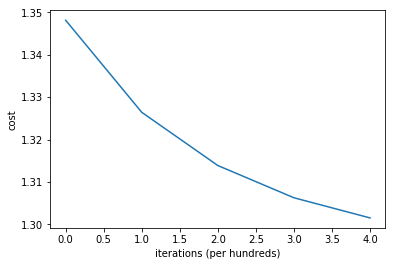

In [7]:
# tensorflow中集合的运用:损失集合
# 计算一个5层神经网络(relu激活函数)带L2正则化的损失函数（均方损失函数）
# 加入学习率的设置（指数衰减）
import matplotlib.pyplot as plt
import tensorflow as tf
# 通过numpy生成模拟数据集
from numpy.random import RandomState

%matplotlib inline

costs = []

# 获得一层神经网络上的权重，并将这个权重的L2正则化损失加入名称为'losses'的集合里
def get_weight(shape,lamada):
    #生成对应一层的权重变量
    var = tf.Variable(tf.random_normal(shape,seed=1),dtype=tf.float32)
    tf.add_to_collection('losses',tf.contrib.layers.l2_regularizer(lamada)(var))
    return var

# 定义输入和输出占位空间
x = tf.placeholder(tf.float32,shape=(None,2),name='x_input')
y_ = tf.placeholder(tf.float32,shape=(None,1),name ='y_input')

# 训练数据批次大小
batch_size=8

# 定义每层神经网络的节点个数
layer_dimension=[2,10,10,10,1]
# 获取神经网络的层数
n_layers = len(layer_dimension)
# 节点输出值，最开始的时候是输入层
cur_layer = x
# 当前层的节点个数
in_dimension = layer_dimension[0]

# 通过一个循环生成5层全连接的神经网络结构
for i in range(1,n_layers):
    #获取下一层节点的个数
    out_dimension = layer_dimension[i]
    #获取当前计算层的权重并加入了l2正则化损失
    weight = get_weight([in_dimension,out_dimension],0.001)
    bias = tf.Variable(tf.constant(0.1,shape = [out_dimension]))
    #计算前向传播节点，使用ReLU激活函数
    cur_layer = tf.nn.relu(tf.matmul(cur_layer,weight)+bias)
    #进入下一层之前，更新下一层节点的输入节点数
    in_dimension = layer_dimension[i]

# 定义均值化损失函数，并加入损失集合，反向传播的算法（梯度下降法）
mse_loss = tf.reduce_mean(tf.square(y_-cur_layer))
tf.add_to_collection('losses',mse_loss)

# get_collection返回一个列表，列表是这个集合的所有元素
# 之前已存有L2正则化的参数，再加上上一步添加进的均方损失值
loss = tf.add_n(tf.get_collection('losses')) # 元素对应相加

global_step = tf.Variable(0)
# 学习率的设置：指数衰减法，参数：初始参数，全局步骤，每训练100轮乘以衰减速度0,96(当staircase=True的时候)
learning_rate = tf.train.exponential_decay(0.1,global_step,100,0.96,staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

# 通过随机数生成模拟数据集
rdm = RandomState(1)
dataset_size=128  # 数据集大小
X = rdm.rand(dataset_size,2) # 维度
#加入了一个噪音值，-0.05～0.05之间
Y = [[x1+x2+rdm.rand()/10.0-0.05] for (x1,x2) in X]  # 定义正确值标签

# 创建会话运行训练过程
with tf.Session() as sess:
    # 初始化变量
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    #print (sess.run(w1))
    
    # 定义训练轮数
    steps = 5000
    for i in range(steps):
        # 每次选取batch_size个样本训练
        start = (i*batch_size)%dataset_size
        end = min(start+batch_size,dataset_size)
        
        # 训练并更新参数,feed_dict喂入数据到占位空间
        sess.run(train_step,feed_dict = {x:X[start:end],y_:Y[start:end]})
        # 打印损失值
        if i%1000==0:
            total_loss = sess.run(
                loss,feed_dict={x:X,y_:Y})
            print("After %d training_step(s) ,loss on all data is %g"%(i,total_loss))
            costs.append(total_loss)
     # 打印训练后的权重值       
    #print (sess.run(w1))
    
# 显示损失曲线
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
#plt.title("Learning rate = 0.001")
plt.show()

In [8]:
#滑动平均模型
#滑动平均模型可以使得模型在测试数据上更加健壮
import tensorflow as tf

#定义一个变量用以计算滑动平均
v1 = tf.Variable(0,dtype=tf.float32)

#模拟神经网络迭代的轮数，动态控制衰减率
step = tf.Variable(0,trainable=False)
#定义一个滑动平均的类，初始化时给定衰减率为0.99和控制衰减率的变量
ema = tf.train.ExponentialMovingAverage(0.99,step)

#定义一个滑动平均的操作，这里需要给定一个列表，每次执行这个操作时，列表里的元素都会被更新
maintain_average_op = ema.apply([v1])

with tf.Session() as sess:
    #初始化所有变量
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    
    #获取滑动平均之后变量的取值
    print(sess.run([v1,ema.average(v1)]))
    
    #更新v1的值为5
    sess.run(tf.assign(v1,5))
    #更新v1的滑动平均值，衰减率为min{0.99,(1+step)/(10+step)=0.1}=0.1,
    #所以v1的滑动平均被更新为0.1*0+0.9*5=4.5
    sess.run(maintain_average_op)
    print (sess.run([v1,ema.average(v1)]))
    
    #更新迭代的轮数
    sess.run(tf.assign(step,10000))
    sess.run(tf.assign(v1,10))
    #这里的衰减率变成0.99
    #v1 = 0.99*4.5+0.01*10=4.555
    sess.run(maintain_average_op)
    print (sess.run([v1,ema.average(v1)]))
    
    #再次更新滑动平均值
    sess.run(maintain_average_op)
    print (sess.run([v1,ema.average(v1)]))

[0.0, 0.0]
[5.0, 4.5]
[10.0, 4.555]
[10.0, 4.60945]
